# **🧠 BORN-AGAIN NEURAL NETWORKS (BANs) FROM SCRATCH.**

*🤝 Purpose: Implementing BANs with Teacher Confidence Weighting and Dark Knowledge Permutations from scratch, and testing said implementations between DenseNet-121 teachers and ResNet-18 student ensembles on the ImageWang Dataset (along with some MLP MNIST tests).*

Traditionally, information has been transferred between teacher and student models via a process known as **Knowledge Distillation** (KD). The goal of KD is simple - to train an initial teacher model, and then train a smaller student model in effort to achieve equivalent performances in a smaller parameter space. 

This student model can be trained in three main ways. The simplest and most common of these is known as **response-based distillation**, where the **distillation loss** is calculated simply by measuring the Euclidean distance between the student and teacher predictions. But, this of course is no guarantee that the student is learning the same underlying relationship as the teacher - **Feature-Based distillation** aims to solve this problem by attempting to match the **feature activations at the end of each layer** (attempting to coerce the student to learn similar feature maps to the teacher). 

More advanced and accurate still is **Relation-Based distillation** - rather than attempting to match the outputs of some layer or model, RKD aims to transfer **structural knowledge** regarding the relationship of different nodes (for example, calculating the angle formed by three given nodes or the distance between them). In any case, the **objective of such methods has always been to DISTILL information into a smaller form.**

This begs the question - if **smaller student models can achieve equivalent accuracies, can student models of equivalent size obtain HIGHER accuracies than their teachers?** This is, fundamentally, a Born-Again Neural Network (BAN) - a student model identically parametrized to its teacher, an effort that *surprisingly leads to the students (drastically) outperforming their respective teacher models.* This project will be replicating the original BAN paper (found at https://arxiv.org/pdf/1805.04770.pdf).

The purpose of this project/mini-experiment is to 1️⃣ **determine whether Dark Knowledge-based relationships (as we'll discuss further) are instrumental in how networks learn and generate predictions**, 2️⃣ understand from first-principles the theoretical nature of BAN distillation losses (Confidence Weighted by Teacher Max and Dark Knowledge with Permuted Predictions) and their practical nature via **implementing them from scratch in PyTorch**, 3️⃣ further uncover why **BANs tend to achieve higher overall accuracies when compared to teachers** (i.e. "re-learning" identical relationships but in more "effective" terms), and 4️⃣ **test the Dark Knowledge and BAN accuracy hypothesis via training an ensemble of 5 WideResNet 28-1 student models against a DenseNet 121 teacher**.

Let's get into it!

## 🤔 **The Math Behind BANs - Confidence Weighting, Dark Knowledge, and More.**

For a typical BAN system, the training procedure looks something like this (where $x$ is the input data, $T$ represents the initial teacher model, $S_k$ represents the $k-th$ student learner, $f(x)$ represents the classifier learned by the model, and $y$ represents the generated predictions):

<p align = "center"><img src = "./images/BAN_TRAINING_PROCEDURE.png"></img></p>

In essence, each student learns from the student that came before it - student $S_k$ learns from student $S_{k-1}$, and student $S_k$ learns from the initial teacher $T$. Once this ensemble has been trained, there are two options: one can either simply take the final student model, or one can "batch" the student models together into **a model ensemble**, where for a given input, the predictions of each model within the ensemble are averaged (or combined in some other way) to generate the final prediction. Generally speaking, model ensembles are prone to **higher accuracies** as they cover a larger proportion of hypothesis space, and thus can fit a wider set of distributions. 

### **👆 What's the point of BANs?**

Fundamentally, the idea of the BAN is that **the teacher model's activations and end prediction distribution (i.e. the probability distribution of whatever predictions have been generated) contain critical information in ADDITION to the training set that can result in better predictions.** Analogically, it is much like a student learning not only the required material, but additional information beyond said material that may drastically boost their academic performance. Mathematically, this operates on the principle that **minimizing the LOSS FUNCTION of a given task is not necessarily the same as minimizing generalization error.**

While a teacher model may have drastically minimized the loss function, this does not meant that it is proficient in the given task; or that the classifier it has learned in hypothesis space is adept enough to fit most possible distribution. But, it is also possible that **in the process of optimizing the loss function, the teacher model stumbled upon some critical insights that can serve to be instrumental in improving model generalization.**

So, if we were to learn **from both the training set AND the teacher**, we increase the amount of potentially relevant available information - the student can now use the teacher's predictions and learned patterns as a starting point, potentially learning more advanced and accurate classifiers.

### **🪄Dark Knowledge - and why it matters.**

Let's say that a certain model is trying to classify a dog, train, car, and cat, and to test the model, we give it a picture of a dog. When we pass in this image and apply the SoftMax activation, we'll get something like this:

*Quick refresher - the SoftMax activation takes a set of input values, and changes them into probabilities between 0 and 1. For a given vector* $z_i$ *,* $\sigma$ *(SoftMax)* $z_i$ *is given by:*

$$ \sigma(z_i) = \frac{e^{z_{i}}}{Σ_{j=1}^{K} e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $$

*In other words - for each logit, it is simply* $e^{prob}$ *divided by the SUM of* $e$ *raised to all of the other probabilities. This function will be important later!*

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
|0.9    | 0.002 | 0.001 |0.0897 |

</center>

Now, if we were trying to extract a prediction from the model, the end answer is simple - the model obviously predicted dog (with the highest probability at 90%). We might even try to use this information as our Knowledge Distillation approach - simply checking if **both the teacher and student model predicted dog as their end prediction**, and using this information to determine how far off the student was from the teacher (the distillation loss).

But, **there's a huge problem with this approach - it ignores the probabilities of the remainder of the labels. More accurately, it ignores the fact that the model stated that the given image was more likely to be a cat than a car, and more likely to be a car than a train.** This might be hard to tell because the numbers are so small - so, let's introduce something known as **temperature** in the above SoftMax formula so that we can see those other predictions better **without affecting the order of the predictions.**

It's pretty simple - all we need to do is **divide each raw output by some temperature constant $T$ to rescale the values before applying SoftMax.** The HIGHER the temperature, the **"softer" the distribution**, and the LOWER the temperature, the "sharper" (more drastic differences between labels) the distribution (generally speaking). Here's SoftMax with temperature:

$$ \sigma(z_i) = \frac{e^{\frac{z_{i}}{T}}}{Σ_{j=1}^{K} e^{\frac{z_{j}}{T}}} \ \ \ for\ i=1,2,\dots,K $$

Now, if we apply an arbitrarily high temperature to our previous distribution: (*note that values are just for demonstration purposes and not real*)

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
|0.4    | 0.09  | 0.04  |0.27   |

</center>

In percentages for clarity:

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
| 40%   | 9%    | 4%    | 27%   |

</center>

Now, we can **clearly see that the model believes that the image is more likely to be a cat than a car** - this indicates that the model **has learned a relationship: that animals are different from objects.** Other ANIMALS are more likely to be confused with other animals, whereas an animal is drastically less likely to be confused with an object like a car. 

#### **This is dark knowledge - hidden relationships the model has learned that can be critical in completing the task at hand that can be found in its underlying probability distribution**. In our example, the model had to first learn that animals $\ne$ things as a critical first step in distinguishing the classes.

So, rather than our distillation loss just checking if both networks predicted the same value, it should instead encompass **the dark knowledge terms** (the remainder of the probability distribution) to capture the underlying dark knowledge that led the network to its end prediction.

If this Dark Knowledge (DK) hypothesis holds true, then **it makes sense that transferring this DK between teachers and students should be critical in KD and in training BANs.** But, **is it really dark knowledge information transfer that makes knowledge distillation successful?**

Let's explore this further.

### 📚 **Is Dark Knowledge Truly Important? Confidence Weighting.**

Remember how I said that the SoftMax function would be useful? Now's time to put it into (further) action.

First, let's understand **cross entropy loss.** The SoftMax function is an **activation - it normalizes our logits, but does NOT tell us the loss.** This is where cross entropy comes in - it compares two SoftMax-activated distributions and **returns the error between the two.** The underlying logic is simple -> simply multiply **the true probability distribution** by the log (usually natural log) of the given distribution **for each value** (i.e. compare the log of the predicted dog values with the actual dog predictions, then the car, train, and cat, etc.) and simply sum them up!

$$ \ell(p, q) = -\sum_{\forall x}p(x)log(q(x)) $$ 

...where $p(x)$ is the true distribution and $q(x)$ is the predicted distribution.

When we perform gradient descent, we must compute the **gradient or partial derivative** of this function with respect to the $i_{th}$ parameter $z_i$ - in other words, we must compute the value of $\frac{\partial \ell}{\partial z_i}$. Here's the cool part: **the partial derivative of the cross entropy loss function is just the predicted distribution minus the true distribution!** And, if we **expand both $q_i$ and $p_i$ to reveal how they were calculated** (remember that the SoftMax activation was applied first to obtain both $q_i$ and $p_i$ - we are simply expressing those two variables in terms of the SoftMax calculation), we get:

$$ \frac{\partial \ell_i}{\partial z_i}=q_i-p_i=\frac{e^{z_i}}{Σ_{j=1}^ne^{z_j}}-\frac{e^{t_i}}{Σ_{j=1}^ne^{t_j}} $$

Remember that, for any given student model, the true distribution for it would be the teacher's distribution (not the distribution of the actual dataset labels). So here, $p_i$ serves as the **teacher's prediction distribution** whereas $q_i$ **serves as the student's prediction distribution.**

Let's suppose for a second, that instead of the $i_{th}$ element of the predictions, we are on the TRUE predicted element (represented by $\ast$). In the context of the previous example, this would mean that we were currently on the "Dog" class, the class/element with the highest probability. Now, let's suppose **that the teacher is EXACTLY accurate for this example - that is, instead of outputting 0.9 or 0.5 for this class, it outputted a perfect 1.0.** In this case, the distribution would look something like this:

<center>

|  Dog  |  Car  | Train |  Cat  |
|-------|-------|-------|-------|
| 1.0   | 0.0   | 0.0   | 0.0   |

</center>

Let's now draw our attention back to $p_i$, which is the SoftMax of $i_{th}$ class prediction (the class predicted by the teacher). Since we are on the highest element (the "true" prediction) and it perfectly matches the "target" distribution (the distribution of the actual dataset (**remember that the dataset, after being one-hot encoded, just has 1 for the true class and 0 for everything else**), then this term **will simply yield 1**! The teacher has outputted a fully confident answer of 100% for a certain class, so its prediction for the highest probability class is 1. 

As a result, the **partial derivative when the teacher's true prediction exactly matches the target distribution (and when we are iterating over that true prediction $*$)** is:

$$ \frac{\partial \ell_i}{\partial z_i}=q_i-p_i=\frac{e^{z_i}}{Σ_{j=1}^ne^{z_j}}-1.0 $$

Now that we know the partial derivative of the loss function when iterating over just one sample of logits (i.e. one prediction distribution), let's consider what would happen if we were to iterate across not only the $i_{th}$ sample, but an entire batch of size $b$. Since we want to find the **average loss** for the entire batch, we can divide the sum of the loss function applied to $x_1, t_1...x_b, t_b$ (where $x_n$ is the prediction and $t_n$ is the true label) by the batch size. **So, the loss of an entire minibatch is given by:**

$$ \ell(x_1,t_1..x_b,t_b)=\frac{1}{b}\sum^{b}_{s=1}\ell(x_s,t_s) $$

Let's keep going. If we wanted to find the gradient of this loss over the entire batch, we would simply find the average gradient across all the PREDICTED samples (the samples with the highest probability), right? In other words, we would take $q_{\ast}-p_{\ast}$ for each sample in the minibatch and then average it. This yields:

$$\frac{1}{b}\sum^b_{s=1}\frac{\partial\ell_{i,s}}{\partial z_{i,s}}=\frac{1}{b}\sum^b_{s=1}(q_{\ast,s}-p_{\ast,s})$$

But, this is missing some key information - namely, **the Dark Knowledge hidden inside the remainder of the probability distribution.** We are computing the gradients over **the true predictions, but NOT the gradients for each probability inside each sample.** We can fix this by adding another term - a **Dark Knowledge Term** - that, **for each sample, iterates over *all logits* rather than just the predicted (max) ones and calculates *their difference from the teacher logits.*** 

**Assume that $n$ is the true label - the last term finds the difference between all logits that are NOT the argmax one (all logits that aren't the maximum prediction/predicted class).**

$$\frac{1}{b}\sum^b_{s=1}\sum^n_{i=1}\frac{\partial\ell_{i,s}}{\partial z_{i,s}}=\frac{1}{b}\sum^b_{s=1}(q_{\ast,s}-p_{\ast,s})+\frac{1}{b}\sum^b_{s=1}\sum_{i=1}^{n-1}(q_{i,s}-p_{i,s})$$

Remember - usually, we would **just consider the first term** (the difference between the predictions for the correct classes). But, if the Dark Knowledge Hypothesis is correct, then the remainder of the probability distribution matters as well. So, we must **also consider these differences for each individual logit as well.**

Let's consider something - we know that the **ground truth prediction for the correct class in the dataset will always be 1.** A given dataset will be one-hot-encoded, or simply have the index of the correct class, but in either case if we were to compute the probabilities they would be (0, 0, 0, 1), where 1 is the probability of the correct class. The probability for the correct class will always be 1 - if $y$ represents the ground truth labels (the actual classes in the dataset_ and $*$ represents the predicted value at the true class, then $y_{\ast,s}$ will always be one - ad then zero whenever it is not on the true class. **What happens if we combine this term $y_{\ast,s}$ with $p_{\ast,s}$**? It might look something like this:

$$ \frac{1}{b}\sum^b_{s=1}(q_{\ast,s}-p_{\ast,s}y_{\ast,s}) $$

We know that $p_{\ast,s}$ (the teacher's predictions for the highest label) will **almost never be 1** - it may reach *a value approximating that* (like 0.9998), but the probability of it achieving one is extremely low. **Importantly, the closer this value is to one** (the condition where if we were to take the limit of this function it would equal 1), **the closer this function becomes to the cross entropy derivative where we simply subtract $q_i$ by 1!**

What happens if $p_{\ast,s}$ is *not* a value close to one? Well, this indicates that **the teacher is not confident in its prediction**, and this will impact the computed gradient (we subtract a smaller value from the student prediction).

What this really means is that *the teacher model is performing a sort of **"confidence weighting" on the samples presented by the dataset - if neither the teacher nor the student are confident in their prediction our gradient update will be less severe (the difference between the two terms becomes smaller).*** This could be highly advantageous - if the teacher is not confident w.r.t a certain sample, it can prevent the student from prematurely entering a local minima or making disastrous updates based one or two awry samples. This, therefore, further aides in ensuring the validity and effectiveness of gradient updates and by extension can help to improve convergence. Let's step away from the example above and **re-write the above expression with $p_{\ast,s}$ as a true weight *for the entire expression* instead of just for $y_{\ast,s}$:**

*Let* $w$ *represent an arbitrary weight - we multiply the weight calculated at sample* $s$ *divided by the weights across the entire minibatch, obtaining, as a percentage, the **size of the weight as compared to other weights in the batch**. In essence, we obtain how "confident" the teacher model is in a certain sample in comparison to its other predictions within the batch (a weight whose size makes up 25% of the entire batch is more confident than a weight that makes up 1%.*

$$\frac{1}{b}\sum^b_{s=1}\frac{w_s}{Σ_{u=1}^b w_u}(q_{\ast,s}-y_{\ast,s})=\frac{1}{b}\sum^b_{s=1}\frac{p_{\ast,s}}{Σ_{u=1}^b p_{\ast,u}}(q_{\ast,s}-y_{\ast,s})$$

So, this begs the question - **does the success of Knowledge Distillation rely on the Dark Knowledge terms, or the confidence weighting shown here?**

To solve this, the paper devises *two different distillation losses* to test just this - **CWTM (Confidence Weighted by Teacher Max) and DKPP (Dark Knowledge with Permuted Predictions0).** The gradient of CWTM is almost exactly what we saw above; with one exception mentioned below:

$$\frac{1}{b}\sum^b_{s=1}\frac{\max p_{.,s}}{Σ_{u=1}^b \max p_{.,u}}(q_{\ast,s}-y_{\ast,s}) $$

**We're weighting by the teacher's CONDFIDENCE - now, we're taking the highest probability as opposed to the probability of the correct label** (which is what we did in the last example). We simply want to see how confident the teacher is in its prediction for a given sample, irrespective of what the right answer is (what is the highest probability as opposed to what is the probability the teacher outputted for the correct label). On the other hand, we of course *do* care about the student's prediction for the correct value.

What about DKPP? Same thing as the equation where we computed the derivative and added the dark knowledge terms - **except this time, we will randomly permute all of the non-max logits of the teacher's predictions to destroy the covariance matrix between the maximum value and the rest of the logits via permutation function $\phi$.** In essence, if it truly is the Dark Knowledge hidden within logits that are important, *then we should see positive impact irrespective of whether those logits are with the right argmax (predicted)value.* **We permute all of the NON-ARGMAX LOGITS - all of the logits that are *not* the maximum prediction - and subtract them from the student distribution, whereas the argmax value remain identical.** 

Looking at the previous table, this would be like replacing the probabilities outputted in the non-predicted classes (all the classes that aren't the maximum value, in that case dog) with probabilities that the model predicted on another sample. This destroys the covariance matrix between the predicted class and the remainder of the classes (all of them usually add up to one; without permuting we have no way of knowing whether its the dark knowledge encoded in the logits or just the fact that all the predictions are correlated that truly is creating improvement). Putting it all together, this is what DKPP looks like:

$$\frac{1}{b}\sum^b_{s=1}\sum^n_{i=1}\frac{\partial\ell_{i,s}}{\partial z_{i,s}}=\frac{1}{b}\sum^b_{s=1}(q_{\ast,s}-\max p_{.,s})+\frac{1}{b}\sum^b_{s=1}\sum_{i=1}^{n-1}(q_{i,s}-\phi(p_{j,s}))$$

That, is going to be the focus of this experiment - **determining whether Dark Knowledge is truly important with regards to Knowledge Distillation as compared to teacher confidence weighting**, and how this plays a role in the performance of BANs (which are really a special case of the aforementioned KD). **

## **🔍 Methodology and About the Experiment/Repo.**

**NOTE - To see the notebook, you may have to clone the repository as GitHub is traditionally not the best at rendering .ipynb files.**

Fundamentally, this experiment is about testing performance of an ensemble of four student BANs on the ImageWang dataset between those trained via the CWTM and DKPP distillations to determine their true importance. **One of the key criticisms of the original paper is that the experimentation process has been done primarily on CIFAR-10 and MNIST** (which, given the ability of even simple networks to achieve near state-of-the-art accuracies on them, is simply not a good way to validate findings), **so this implementation will test the findings on the more complex ImageWang dataset (a subset of the larger ImageNet set):** 

*Some samples from the ImageWang dataset:*

<p align = "center"><img src = "./images/IMAGEWANG_SAMPLE_IMAGES.png"></img></p>

All loss functions have been implemented **from scratch** with PyTorch with custom backward methods - the forward methods of both these losses find the cross entropy between the student and teacher distributions (implemented from scratch too since PyTorch as of now only supports CE between labels and distributions), as you'll find in the repo. Check the individual files for more details on implementation!

**The teacher model will be the DenseNet-121, whereas the student models will be the ResNet18 - the latter is known to be more simple due to skip connections going only to the incoming layer, and will help determine whether a strong teacher can teach a weaker student of roughly the same number of parameters and have the BAN student (ResNet 18) exceed it in performance.**

Here's a quick diagram illustrating the architectures used (made in PowerPoint, images from https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8 and https://www.researchgate.net/figure/Architecture-of-the-ResNet-18-model-used-in-this-study_fig3_354432343):

<p align = "center"><img src = "./images/DENSENET121_RESNET18_DIAGRAM.png"></img></p>

(Note: check out this article https://medium.com/@smallfishbigsea/densenet-2b0889854a92 for more information on DenseNets and ResNets! :D)

🖱️**There are 4 key parts to this repository:**

- `CWTM_Distillation.py` - implementation of the CWTM Distillation loss/gradient.
- `DKPP_Distillation.py` - implementation of the DKPP Distillation loss/gradient computation.
- `BANs_Experimentation.ipynb` - the site of the data processing, training, and experimentation process.
- `Test_Distillations.py` - a testing script that a) passes in a couple sample tensors into the aforementioned distillation implementations and then trains them on MNIST to judge whether the gradients are flowing smoothly. **To test the distillations individually, run `python [distillation loss].py` in your terminal of choice.

Feel free to clone this repository and try out the notebook yourself! Due to a lack of compute, I just conducted the Densenet121 to BAN ResNet18 experiment; it'd be interesting to see how other models perform in this regard (and if the BAN ResNet18 can even serve as a teacher model; as was done in the paper with a WideResNet28-1)!

## 🎯 **Results and Next Steps.**

As a proof of concept, I first ran a single BAN MLP for ~750 samples (1 epoch) on the MNIST dataset, just to make sure the gradients were flowing smoothly and the implementation of the above formulas was correct. After a couple days of debugging, the BAN obtained roughly 71% accuracy after a single epoch (compared to the teacher of the same architecture which was trained on 10). As the test was meant mainly to validate that the entire setup + algorithmic implementation was up to standard, no more training was done (with the real test of the BAN being with the BAN ResNet and DenseNets). 

**Here are the initial test results from the CWTM Distillation:**

<p align = "center"><img src = "./images/CWTM_BAN_MNIST_TEST_RESULTS.png"></img></p>

**and from the DKPP Distillation:**

<p align = "center"><img src = "./images/DKPP_BAN_MNIST_TEST_RESULTS.png"></img></p>

There are some interesting trends visible here. Right off the bat, its clear to see that the **DKPP distillation model completely fails to converge -** the gradient updates look much like random noise, and the training loss slowly increases over time (the model gets worse and worse as it sees new samples). 

This is rather interesting. DKPP on harder tasks converged in the actual paper (and performed slightly better than CWTM), though despite this implementation being correct to my knowledge (having spent days rechecking, revising, and modifying the DKPP distillation to resemble that of the paper), it failed to converge on MNIST! **On the other hand, the CWTM distillation loss within 2000 steps was able to converge, and if training steps were continued, it is very well possible that the seen accuracy increase would have continued.** Let me know if you have any suggestions/notice anything about this particular DKPP implementation that may explain this!

Why did the DKPP distillation loss fail to converge? My hypothesis here is that the dark knowledge encoded within the non-argmax logits resulted in strong gradient updates insofar as the covariance matrix between the argmax and non-argmax logits was maintained. In other words, it was not the Dark Knowledge within the logits that was useful, but rather that gradient computations were being performed on the entire student and teacher samples as opposed to just the argmax logits. **The second the non-argmax logits were shuffled (and the covariance matrix destroyed), the added benefit that stemmed from increased data points per sample instead became random noise that simply dampened the true signal for each sample (as the permuted logits did not correspond to the given argmax value - the gradients generated for the logits would be different from the argmax sample).** 

If that hypothesis is true, I wonder how we can better encode the dark knowledge of teacher networks than through the non-argmax logits - potentially combining the above DKPP method with something such as Relational KD to get a more accurate picture of the relationships the teacher has learned!

**Here are the results from the ResNet18 test: (CWTM)**

<p align = "center"><img src = "./images/IMAGEWANG_RESULTS.png"></img></p>

Interestingly, all 4 students achieved roughly the same accuracy after 10 epochs of training. **Throughout this entire process, losses and accuracies for each student were improving steadily - but, due to compute limitations, I decided to train for only 10 epochs** (which took a couple days of continuous training to accomplish, running on an Intel i3). Still, these results are fascinating -> as a proof of concept, the strong updates *(check the notebook for the exact updates)* further validate the performance of CWTM.

Given that DKPP failed to converge even on MNIST, it didn't make sense to spend another 3 days training the ResNet18 ensembles on said distillation - I'll be working to make my own modifications to DKPP to **improve convergence, and eventually retrain all student ensembles on a GPU-enabled device!**

**🪜 Next Steps involve:**

- 📝 **Rewriting the DKPP distillation loss and adding custom terms to improve convergence.** 
- 🧑‍💻 Figuring out the compute situation, and then **retraining all student ensembles for 100+ epochs for both CWTM and DKPP** to further improve the validity of the BAN performance findings.
- 🧪 Testing **different BAN combinations** - DenseNet and BAN WideResNet, WideResNet with DenseNet, DenseNet to DenseNet, and different architectures within each one of these combinations!

This project marks the end of the "1 DL project a week" effort -> **I'll now be taking two weeks to work on a more advanced research problem, and publish a pseudo-paper with my findings (especially intrigued with memory-based optimizers and improving gradient flow).**

Excited to see what comes next!

## 🔑 **Key Learnings and Final Thoughts.**

Everything considered, this is probably the most advanced project I've done yet - not necessarily in terms of the end product/process, but in terms of understanding gradient flow and calculations from first-principles (having implemented those for both distillation functions), learning to place existing concepts and problems in different scenarios to reveal new behaviour (for instance, the paper took the regular dark knowledge distillation loss and considered what would happen if we were to involve $y_{\ast,s}$, revealing that the function was acting as a confidence weight of sorts), and sheer debugging (how to handle different matrix operations, how grad shapes correspond to parameters, the problem with rapidly increasing model certainty, and more)!

Understanding the math straight from the paper also proved to be a challenge - I spent a couple hours rereading, rewriting, and re-thinking each listed equation until it made intuitive sense (a process that took a couple hours). The reward? **Clear understanding and a hands-on knowledge regarding knowledge distillation terms like dark knowledge, gradient computations and manipulation, and a huge repository for future ideas.** Innovation can only transpire if one first understands their craft on a deep, non-verbal level, and it was awesome to delve "deep" into "deep learning research :D (bad pun).

That being said, here are the top 3 learnings from this project:

1. 🎓 **The true learned classifier of a neural network consists of multiple, building-block factions that all play key roles.** One of the most useful parts of Knowledge Distillation is that it **forces researchers to better understand what constitutes a given representation**, as one cannot distill something without understanding all the components that make it functional. The prime example of this would be Dark Knowledge - the relationships *between* the predictions of *all* classes are of equivalent (or perhaps greater) importance than that of obtaining the correct class. **How can we better understand and distill the relationships learned by classifiers?**

2. ⚒️ **Practically implementing more advanced gradient operations in PyTorch + understanding how gradient flow works and affects the performance of a model.** At one point, the BAN MLP model in the testing script stopped learning. More accurately, the loss function became constant, and further inspection revealed that the BAN was learning **to make CONFIDENT predictions as opposed to CORRECT predictions.** Attempting to debug this, I took a look at the gradients - and found that **the prediction for the highest label approached 1 as the gradient approached -0.002**. The reason the gradients were sterilizing at that value? **The gradients updates, were vectors as opposed to matrices**, meaning that each input had just one gradient per sample as opposed to one per class. I modified the CWTM and DKPP distillation gradients to include **the entire sample probability distribution** as opposed to **the difference between the true predictions**, ensuring that gradients flowed smoothly. You can see exactly what I did in `CWTM_Distillation_Loss.py` or by checking the commit history - this experience was critical and helped serve as a visceral reminder regarding the on-the-ground impact of the gradient functions wrote (as well raising questions about what information can be extracted from looking at *what values the gradient sterilize at*)!
   
3. 🔁 **The mathematical foundations behind BANs and Knowledge Distillation.** Reading over the BAN paper led me down a rabbit hole of sorts regarding Knowledge Distillation - I ended up reading additional papers such as that on Relational KD, and was exposed to the reasoning behind certain distillation losses, how inter-parameter relationships in param space, such as the angles between coordinates, can be indicative of interconnections and their strength. Pursuing the understanding of both CWTM and DKPP distillations further "rigorified" (if that's a word) my mathematical understanding of basic deep learning tasks such as classification, and provided valuable mathematical breeding ground for future ideas (such as memory-based optimizers). **I've broken down all of the math behind KD and Distillation losses in even further detail in my notes, which you can find at https://crysta.notion.site/BORN-AGAIN-NEURAL-NETWORKS-KNOWLEDGE-DISTILLATION-AND-BANs-a2c5b44ba5dd430e8ef954d9f9f854c0)**.

4. 🔑 **The importance of compute and optimization.** As mentioned in the Results section, one of the key limitations of this project was available compute. Despite the losses and accuracies improving for all student ensembles, the fact that I was only able to train them for 10 epochs (due to the fact that I'm training these models on an Intel i3 10th gen as a student) limited the end results to just around 25% end accuracy, whereas simply training for somewhere near 100 if current trends continue would in all likelihood result in 90%+ accuracy on the given ImageWang dataset. I'll be looking into options like VMs and running multiple Google Colab instances to remove this as a barrier in the future. **For now, if you have the resources to do so, feel free to clone this repo and run the notebook cells yourself for a far larger number of epochs to further validate the findings!**

Overall, this project was a fantastic catalyst for my understanding of deep learning and introduced me to more advanced principles within the field. Now, I'm looking to take the knowledge I've learned over the last 3 projects + last year and leverage that to perform research of my own, with a mock paper published in the next few weeks. 

Stay tuned, and enjoy the repo! Hope this was a good read, and would love any feedback or suggestions!

*Special thanks to Tommaso Furlanello, Zachary C. Lipton, Micheal Tschannen, Laurent Itti, and Anima Anandkumar for the original BAN paper (which can be found at https://arxiv.org/pdf/1805.04770.pdf)! This was AWESOME to replicate and drastically improved my understanding of Knowledge Distillation, deep learning, and how networks learn different representations.*

In [1]:
#Import Libaraies
from fastai.vision.all import * 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset. We will be testing the teacher and student models, first and foremost, on the Imagenet Dataset
#This is as one of the key criticisms of the original paper was that only CIFAR-100 was used to validate the given findings
#As actually training a model on the full ImageNet dataset would require more compute, processing pwoer, and time than currently available, use 
#FastAI's Imagenette and Imagewoof instead - combined into one, the Imagewang dataset.

#Use the 160 px version to save training time
Imagewang_path = untar_data(URLs.IMAGEWANG_160)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


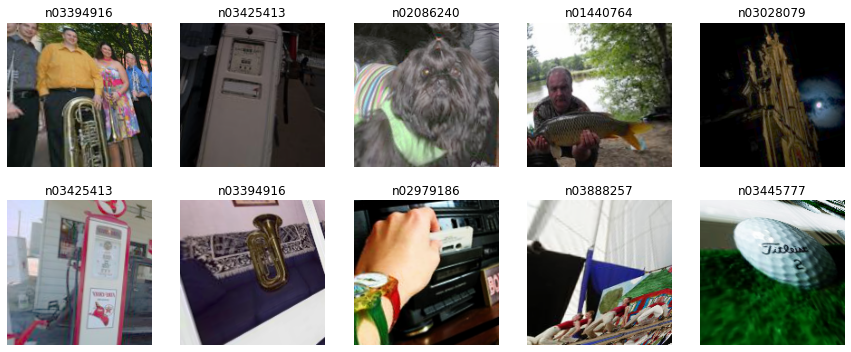

In [3]:
#Create Training Datablock for the teacher model
teacher_train_datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                                       get_items = get_image_files,
                                       get_y = parent_label,
                                       splitter = RandomSplitter(valid_pct = 0.25, seed = 25),
                                       batch_tfms = aug_transforms(mult = 2.),
                                       item_tfms = Resize(160))
#Create a dataloader for the teacher model
batch_size = 64
teacher_train_dataloader = teacher_train_datablock.dataloaders(source = Imagewang_path/"train", batch_size = batch_size, shuffle = True)
#Print sample batch of 10 samples
teacher_train_dataloader.train.show_batch(max_n = 10, nrows = 2)

#### **TRAIN TEACHER MODEL (DENSENET 121).**

In [ ]:
#Load a pretrained Densenet-121 from FastAI to be used as an initial teacher model. The objective is to get the student ensemble (composed of the less complex ResNets)
#to surpass the accuracy of the teacher model.
#T - teacher model, S - student model
DenseNet121_learner_T = vision_learner(teacher_train_dataloader, densenet121, metrics = [accuracy, error_rate])
#Train the model on 10 epochs - as the model is already pretrained, this is morethan sufficient
#Ensure that the model layers are all frozen for the entire training procedure
n_epochs = 10
lr = 0.001
DenseNet121_learner_T.fine_tune(n_epochs, lr, n_epochs, cbs = [ShowGraphCallback])

In [11]:
#Save DenseNet model
DenseNet121_learner_T.save("DENSENET_121_TEACHER")

Path('models/DENSENET_121_TEACHER.pth')

#### **IMPLEMENT STUDENT MODEL LOGIC.**

In [8]:
#Import distillation loss fuctions - CWTM (Confidence Weighting by Teacher Max) and DKPP (Dark Knowledge with Permuted Predictions)
from CWTM_Distillation import CWTM_DistillationLoss
from DKPP_Distillation import DKPP_DistillationLoss
#Import torch.nn.functional for one-hot encoding
import torch.nn.functional as F
#Import tqdm for progress bar
from tqdm import tqdm

#Train student model ensembles
def trainStudentEnsembles(initial_teacher, student_model_type, n_students = 5, optimizer = Adam, lr = 0.001, epochs = 10, CWTM = True, DKPP = False):
    #Set distillation loss string
    if CWTM: distillation = "CWTM"
    else: distillation = "DKPP"
    #Generate new datablock and dataloader for student ensembles
    student_train_datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                                        get_items = get_image_files,
                                        get_y = parent_label,
                                        splitter = RandomSplitter(valid_pct = 0.25, seed = 25),
                                        batch_tfms = aug_transforms(mult = 2.),
                                        item_tfms = Resize(160))
    student_train_dataloader = student_train_datablock.dataloaders(source = Imagewang_path/"train", batch_size = batch_size, shuffle = True)

    #Iterate over number of student models
    for student_number in tqdm(range(1, n_students), desc = "CURRENT STUDENT", colour = "green", bar_format = '{l_bar}{bar:40}{r_bar}{bar:-40b}'):
        print('STUDENT [{}]:'.format(student_number))
        #For each student model, generate a new learner object
        globals()[student_model_type.__name__.upper() + "_" + str(student_number) + "_S_" + distillation] = vision_learner(student_train_dataloader, student_model_type, metrics = [accuracy, error_rate], pretrained = False)
        #Set optimizer
        globals()[student_model_type.__name__.upper() + "_" + str(student_number) + "_S_" + distillation].opt = optimizer(globals()[student_model_type.__name__.upper() + "_" + str(student_number) + "_S_" + distillation].parameters(),
                                                                                                lr)
        #Check if we are on the first iteration (i.e. no student models have been trained) - in this case, use the initial teacher model as the teacher
        #rather than the previous student
        if student_number == 1:
            globals()[student_model_type.__name__.upper()  + "_" + str(student_number) + "_S_" + distillation + "metrics"] = trainStudent(globals()[student_model_type.__name__.upper() + "_" + str(student_number) + "_S"], 
                                                                                                             initial_teacher, epochs, CWTM, DKPP)
        else:
            #If we are not on the first iteration, use the previous student model as the teacher
            globals()[student_model_type.__name__.upper()  + "_" + str(student_number) + "_S_" + distillation + "metrics"] = trainStudent(globals()[student_model_type.__name__.upper() + "_" + str(student_number) + "_S"], 
                                                                                                             globals()[student_model_type.__name__.upper() + "_" + str(student_number-1) + "_S"], 
                                                                                                             epochs, CWTM, DKPP)
        #Save student model
        globals()[student_model_type.__name__.upper()  + "_" + str(student_number) + "_S_" + distillation].save(student_model_type.__name__.upper() + "_STUDENT_" + str(student_number) + "_" + distillation + "_MODEL")

#Import mode for mode calculations
from statistics import mode
#Generate predictions from student model ensembles
def getStudentEnsemblePredictions(input, student_model_type, n_students):
    #Logits and final predictions - these will be averaged to find the logits and predictions of the ensemble
    all_logits, all_predictions = []
    #Iterate over each student
    for student in n_students:
        logits, _, prediction = globals()[student_model_type.upper() + "_" + student + "_S"].predict(input)
        all_logits.append(logits)
        all_predictions.append(prediction)
    #Find the average of all logits and the MODE of all predictions (as they are categorical)
    avg_logits = sum(all_logits)/len(all_logits)
    mode_prediction = mode(all_predictions)
    #Return average logits and most common prediction
    return avg_logits, mode_prediction

#Train function for indiivdual student models
def trainStudent(student_model, teacher_model, epochs = 10, lr = 0.001, batch_size = 64, CWTM = True, DKPP = False):
    #Create metrics dictionary
    metrics = {"TRAIN" : {"loss" : None, "accuracy" : None}, "VALID" : {"loss" : None, "accuracy" : None}}
    #Iterate over epochs
    for epoch in range(epochs):
        #Training loop, store losses and accuracies in respective dictionary elements
        train_loss, train_acc = modelCycle(student_model, teacher_model, epoch, CWTM, DKPP)
        metrics["TRAIN"]["loss"] = train_loss
        metrics["TRAIN"]["accuracy"] = train_acc
        #Validation loop (same structure as above)
        valid_loss, valid_acc = modelCycle(student_model, teacher_model, epoch, CWTM, DKPP, valid = True)
        metrics["VALID"]["loss"] = valid_loss
        metrics["VALID"]["accuracy"] = valid_acc
        #If on the last epoch, return metrics
        if epoch == epochs - 1: return metrics

#Function to handle training loop
def modelCycle(student_model, teacher_model, epoch, CWTM, DKPP, valid = False):
    batch_losses = []
    accuracies = []
    #For each epoch, iterate over a batch (the dataloader used already has this parameter specified)
    #batch_data currently holds the TRUE (y) labels of the dataset
    for batch_number, batch_data in enumerate(teacher_model.dls.train, 0):
        #Set student model gradient to zero
        student_model.zero_grad()
        #Get inputs and true labels
        inputs, y_labels = batch_data
        #Generate student predictions
        student_preds = student_model.model(inputs)
        #Generate teacher predictions
        teacher_preds = teacher_model.model(inputs)
        #Define loss function and calculate the loss
        loss_func = CWTM_DistillationLoss.apply
        #Calculate the loss
        loss = loss_func(student_preds, teacher_preds, y_labels)
        #If this is a validation loop, do not compute gradients or take a step
        if not valid:
            #Compute gradients based on loss
            loss.backward()
            #Take a step with the optimizer
            student_model.opt.step()
        #Add loss to batch_losses array - use .item to convert scalar to float
        batch_losses.append(loss.item())
        #Calculate accuracy - first squeeze true preds and teacher preds
        true_student_preds, true_student_pred_labels = torch.max(student_preds, dim = 1)
        true_student_pred_labels.squeeze_()
        y_labels.squeeze_()
        #Evaluate accuracy based on the TRUE LABELS (as that is our true benchmark)
        accuracy = 100 * torch.eq(true_student_pred_labels, y_labels).sum().item() / batch_size
        accuracies.append(accuracy)
        #Print minibatch statistics
        print("MINIBATCH [{}] LOSS: {} ACCURACY: {}%".format(batch_number, loss.item(), round(accuracy, 2)))
        #Check if we are on the final sample of the batch - if so, output metrics
        if batch_number == batch_size - 1:
            #Calculate average batch loss and append to losses array
            avg_batch_loss = sum(batch_losses)/len(batch_losses)
            #Calculate accuracy
            avg_accuracy = sum(accuracies)/len(accuracies)
            #Display loss and accuracy
            print("TRAINING EPOCH [{}]: LOSS = {}, ACCURACY = {}".format(epoch, avg_batch_loss, avg_accuracy))
            #Return batch loss and accuracy
            return avg_batch_loss, avg_accuracy

#### **TRAIN STUDENT MODELS ON DENSENET TEACHER.**

In [6]:
#Redeclare DenseNet121 Learner
DenseNet121_learner_T = vision_learner(teacher_train_dataloader, densenet121, metrics = [accuracy, error_rate])
#Load model
DenseNet121_learner_T.load('DENSENET_121_TEACHER')

In [9]:
#Train students with CWTM (Confidence Weighting by Teacher Max) Distillation Loss
trainStudentEnsembles(DenseNet121_learner_T, resnet18)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


CURRENT STUDENT:   0%|                                        | 0/4 [00:00<?, ?it/s]

STUDENT [1]:
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.5667)
MINIBATCH [0] LOSS: 297.96600341796875 ACCURACY: 3.12%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3598)
MINIBATCH [1] LOSS: 288.8450927734375 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.4103)
MINIBATCH [2] LOSS: 280.34912109375 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.1374)
MINIBATCH [3] LOSS: 262.7593688964844 ACCURACY: 14.06%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.7499)
MINIBATCH [4] LOSS: 251.52027893066406 ACCURACY: 9.38%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.1720)
MINIBATCH [5] LOSS: 265.6501159667969 ACCURACY: 7.81%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.8336)
MINIBATCH [6] LOSS: 245.88880920410156 ACCURACY: 9.38%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.9485)
MINIBATCH [7] LOSS: 264.7176513671875 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.2021)
MINIBATCH [8] LOSS: 269.55609130859375 ACCURACY: 1.56%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.0102

CURRENT STUDENT:  25%|██████████                              | 1/4 [10:07:01<30:21:03, 36421.08s/it]

STUDENT [2]:
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3527)
MINIBATCH [0] LOSS: 298.8894348144531 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3662)
MINIBATCH [1] LOSS: 289.22100830078125 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.9413)
MINIBATCH [2] LOSS: 291.25213623046875 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.5330)
MINIBATCH [3] LOSS: 267.327392578125 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.8574)
MINIBATCH [4] LOSS: 244.2115478515625 ACCURACY: 7.81%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.9030)
MINIBATCH [5] LOSS: 242.960205078125 ACCURACY: 3.12%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.6546)
MINIBATCH [6] LOSS: 266.5545654296875 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.6890)
MINIBATCH [7] LOSS: 240.9159393310547 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.2216)
MINIBATCH [8] LOSS: 245.66458129882812 ACCURACY: 3.12%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.7900)


CURRENT STUDENT:  50%|████████████████████                    | 2/4 [12:58:23<11:41:30, 21045.46s/it]

STUDENT [3]:
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.9861)
MINIBATCH [0] LOSS: 306.60699462890625 ACCURACY: 0.0%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.7501)
MINIBATCH [1] LOSS: 283.0750732421875 ACCURACY: 3.12%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.9854)
MINIBATCH [2] LOSS: 272.5652770996094 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3236)
MINIBATCH [3] LOSS: 284.4576721191406 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3750)
MINIBATCH [4] LOSS: 290.38360595703125 ACCURACY: 7.81%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.4436)
MINIBATCH [5] LOSS: 286.0904846191406 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.7596)
MINIBATCH [6] LOSS: 299.9694519042969 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.5500)
MINIBATCH [7] LOSS: 278.0536804199219 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.1715)
MINIBATCH [8] LOSS: 273.0491638183594 ACCURACY: 4.69%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.0853)


CURRENT STUDENT:  75%|██████████████████████████████          | 3/4 [15:36:14<4:22:40, 15760.18s/it] 

STUDENT [4]:
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.5852)
MINIBATCH [0] LOSS: 295.9732971191406 ACCURACY: 3.12%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3822)
MINIBATCH [1] LOSS: 295.7516784667969 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.3391)
MINIBATCH [2] LOSS: 272.0087890625 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.4467)
MINIBATCH [3] LOSS: 288.68841552734375 ACCURACY: 0.0%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.9437)
MINIBATCH [4] LOSS: 272.8639221191406 ACCURACY: 14.06%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.1735)
MINIBATCH [5] LOSS: 270.89404296875 ACCURACY: 6.25%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.8703)
MINIBATCH [6] LOSS: 250.91847229003906 ACCURACY: 12.5%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.9795)
MINIBATCH [7] LOSS: 254.24534606933594 ACCURACY: 9.38%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(4.4740)
MINIBATCH [8] LOSS: 275.0384521484375 ACCURACY: 9.38%
TRUE LABEL CROSSENTROPY LOSS:  TensorBase(3.7030)
MIN

CURRENT STUDENT: 100%|████████████████████████████████████████| 4/4 [19:11:15<00:00, 17268.87s/it]  


In [ ]:
#Feel free to experiment with this one! Since DKPP didn't converge on MNIST (see README or the description at the top)
#it didn't make sense to perform this test - see if you can improve the performance on this!
#Train students with DKPP (Dark Knowledge with Permuted Predictions) Distillation Loss
trainStudentEnsembles(DenseNet121_learner_T, resnet18, CWTM = False, DKPP = True)

*Note - part of the end reason behind the lower end accuracies is a lack of compute. As seen, the accuracies increase and the CWTM/DKPP losses decrease for the first 10 epochs - with increased training resources (the models were currently trained on an Intel Core i3 10th Gen), this process could be continued for hundreds of epochs to achieve higher accuracies.*